# Ordered MNIST digits examample from Kostic et al. NeurIPS 2022

## Data pipeline

In [1]:
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml')

In [2]:
#Data pipeline
from datasets import load_dataset, interleave_datasets, DatasetDict
MNIST = load_dataset('mnist', keep_in_memory=True)
digit_ds = []
for i in range(configs.classes):
    digit_ds.append(MNIST.filter(lambda example: example['label'] == i, keep_in_memory=True, num_proc=8))
ordered_MNIST = DatasetDict()
#Order the digits in the dataset and select only a subset of the data
for split in ['train', 'test']:
    ordered_MNIST[split] = interleave_datasets([ds[split] for ds in digit_ds], split=split).select(range(configs[f'{split}_samples']))

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

train example: [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
test example: [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]


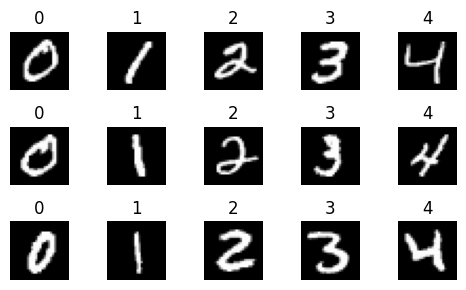

In [3]:
#Checking the data
for split in ['train', 'test']:
    print(f'{split} example: {ordered_MNIST["train"]["label"][:configs.classes*3]}')
import matplotlib.pyplot as plt
n_rows = 3
fig, ax = plt.subplots(n_rows, configs.classes, figsize=(configs.classes, n_rows))
for i in range(configs.classes):
    for j in range(n_rows):
        data = ordered_MNIST['train'][configs.classes*j + i]
        ax[j, i].imshow(data['image'], cmap='gray')
        ax[j, i].set_title(data['label'])
        ax[j, i].axis('off')
fig.tight_layout()

In [4]:
#Cast to float32 and normalize to [0, 1]
ordered_MNIST.set_format(type='torch', columns=['image', 'label'])
ordered_MNIST = ordered_MNIST.map(lambda example: {'image': example['image']/255.0, 'label': example['label']}, batched=True, keep_in_memory=True, num_proc=2)
#Creating a copy of the dataset in numpy format
np_ordered_MNIST = ordered_MNIST.with_format(type='numpy', columns=['image', 'label'])

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time.

### Defining the _oracle_ classifier

In [15]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

We wrap the oracle classifier around a `kooplearn.abc.TrainableFeatureMap`. This will allow us to easily replicate the setting of Kostic et al. 2022, and it is pedagogical to show how `kooplearn` can be extended.

In [ ]:
from kooplearn.abc import TrainableFeatureMap
#Following kooplearn implementations, we define a Pytorch Lightning module (even though it is not necessary)
class ClassifierModule(L.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        output = self.encoder(images)
        loss = self.loss_fn(output, labels)
        self.log('val_loss', loss)
        return loss
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer_kwargs: dict,
                callbacks_fns: list[Type[L.Callback]] = None, 
                callbacks_kwargs: list[dict] = None,
                logger_fn: Type[Logger] = None, 
                logger_kwargs: dict = {},
                seed: Optional[int] = None  
                ):
        #Set rng seed
        L.seed_everything(seed)
        self.seed = seed

        self._lightning_module = ClassifierModule(num_classes, learning_rate)

        #Init trainer
        self._initialize_callbacks(callbacks_fns, callbacks_kwargs)
        self._initialize_logger(logger_fn, logger_kwargs)
        self._initialize_trainer(trainer_kwargs)

        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    def _initialize_logger(self, logger_fn, logger_kwargs):
        if logger_fn is not None:
            self.logger = logger_fn(**logger_kwargs)
        else:
            self.logger = None

    def _initialize_callbacks(self, callbacks_fns, callbacks_kwargs):
        """Initializes the callbacks."""
        if callbacks_fns is not None:
            if callbacks_kwargs is not None:
                assert len(callbacks_fns) == len(callbacks_kwargs)
            else:
                _kw = [{} for _ in callbacks_fns]
            self.callbacks = [fn(**kwargs) for fn, kwargs in zip(callbacks_fns, _kw)]
        else:
            self.callbacks = []

    def _initialize_trainer(self, trainer_kwargs):
        """Initializes the trainer."""
        self.trainer = L.Trainer(**trainer_kwargs, callbacks=self.callbacks, logger=self.logger)
    
    def save(self, path: os.PathLike):
        path = Path(path)
        create_base_dir(path)
        raise NotImplementedError

    @classmethod
    def load(cls, path: os.PathLike):
        raise NotImplementedError

    def fit(self, datamodule: L.LightningDataModule):
        """Fits the DPNet feature map.

        A datamodule is required for this model.

        Parameters:
            datamodule (lightning.LightningDataModule): `Pytorch Lightning datamodule <https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule>`_.
        """
        self.trainer.fit(model=self._lightning_module, datamodule = datamodule)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X).float()
        X.to(self._lightning_module.device)
        self._lightning_module.eval()
        with torch.no_grad():
            embedded_X = self._lightning_module.encoder(X)
            embedded_X = embedded_X.detach().numpy()
        return embedded_X

## Fitting some models with `kooplearn`

In [7]:
from kooplearn.models import DMD, KernelDMD
from kooplearn._src.context_window_utils import trajectory_to_contexts

In [11]:
context_len = 2
train_data = trajectory_to_contexts(np_ordered_MNIST['train']['image'], context_len)
train_data = train_data.reshape(train_data.shape[0], context_len, -1)